In [22]:
import math
import torch
import itertools
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import torch.profiler as profiler
from tensorboardX import SummaryWriter
import datetime
import warnings
import torch.utils.data as data_utils
warnings.filterwarnings('ignore')

# Retrieve data

In [23]:
parquet_file = '../data/D16.04.27G04.26.18.25.50.parquet'
df_by_store = pd.read_parquet(parquet_file)
df_by_store

,date,resource_id,earnings
0,2016-04-27,1,197311.539083
1,2016-04-27,2,146640.343591
2,2016-04-27,3,83049.201349
3,2016-04-27,4,50834.116619
4,2016-04-27,5,41600.032533
...,...,...,...
0,2021-04-25,1,79689.614124
1,2021-04-25,2,171168.014765
2,2021-04-25,3,107963.660107
3,2021-04-25,4,15664.154214


In [24]:
writer = SummaryWriter('logs')

Text(0, 0.5, 'Earnings')

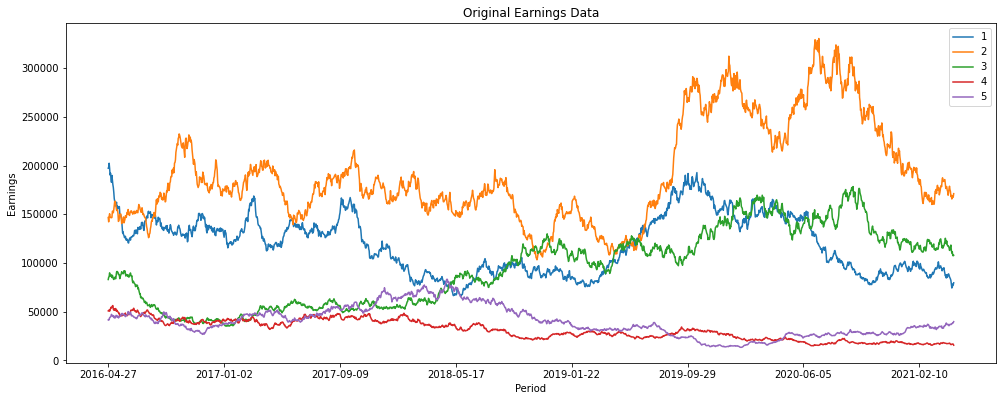

In [25]:
fig, ax = plt.subplots(figsize=(1600/96., 600/96.))
for key, grp in df_by_store.groupby(['resource_id']):
    ax = grp.plot(ax=ax, kind='line', x='date', y='earnings', label=key)
leg = ax.legend()
plt.title(f'Original Earnings Data')
plt.xlabel('Period')
plt.ylabel('Earnings')



## Start with Aggregate Data

In [26]:
# get cumulative earnings into sequence
df_stores_total_daily = df_by_store.groupby(by=['date']).sum()['earnings'].reset_index()
df_stores_total_daily.head()

,date,earnings
0,2016-04-27,519435.233176
1,2016-04-28,519452.879999
2,2016-04-29,529583.377875
3,2016-04-30,531999.483430
4,2016-05-01,520668.272661


In [27]:
df_stores_total_daily['Year'] = pd.to_datetime(df_stores_total_daily['date']).dt.year
df_stores_total_daily['Month'] = pd.to_datetime(df_stores_total_daily['date']).dt.month
df_stores_total_daily['WeekOfMonth'] = pd.to_datetime(df_stores_total_daily['date']).dt.day.apply(lambda day: math.ceil(int(day)/7))
df_stores_total_daily['WeekOfYear'] = pd.to_datetime(df_stores_total_daily['date']).dt.week
df_stores_total_daily['DayOfMonth'] = pd.to_datetime(df_stores_total_daily['date']).dt.day
df_stores_total_daily['DayOfYear'] = pd.to_datetime(df_stores_total_daily['date']).dt.dayofyear

df_stores_total_daily.head()

,date,earnings,Year,Month,WeekOfMonth,WeekOfYear,DayOfMonth,DayOfYear
0,2016-04-27,519435.233176,2016,4,4,17,27,118
1,2016-04-28,519452.879999,2016,4,4,17,28,119
2,2016-04-29,529583.377875,2016,4,5,17,29,120
3,2016-04-30,531999.483430,2016,4,5,17,30,121
4,2016-05-01,520668.272661,2016,5,1,17,1,122


In [28]:
# get cumulative earnings into sequence
df_stores_total_monthly = df_stores_total_daily.groupby(by=['Month','Year']).sum()['earnings'].reset_index()
df_stores_total_monthly.head()

,Month,Year,earnings
0,1,2017,1.292345e+07
1,1,2018,1.356725e+07
2,1,2019,1.287119e+07
3,1,2020,1.910196e+07
4,1,2021,1.430104e+07


Text(0, 0.5, 'Earnings')

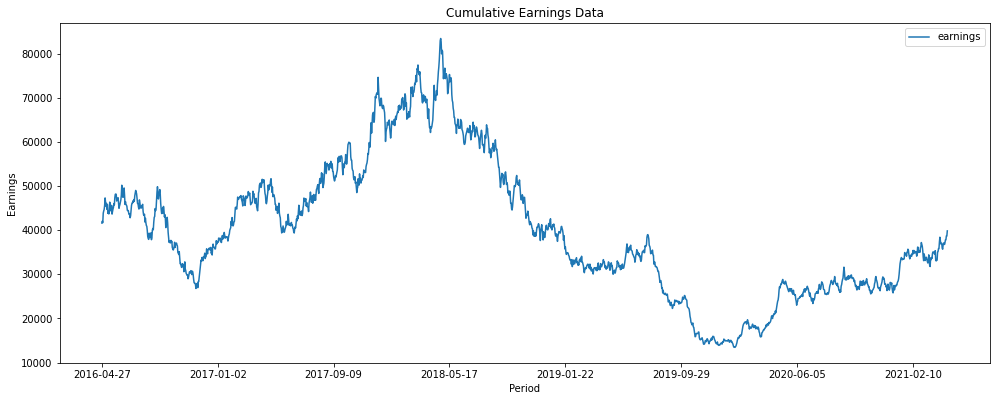

In [29]:
fig, ax = plt.subplots(figsize=(1600/96., 600/96.))
ax = grp.plot(ax=ax, kind='line', x='date', y='earnings')
leg = ax.legend()
plt.title(f'Cumulative Earnings Data')
plt.xlabel('Period')
plt.ylabel('Earnings')


Text(0, 0.5, 'Earnings')

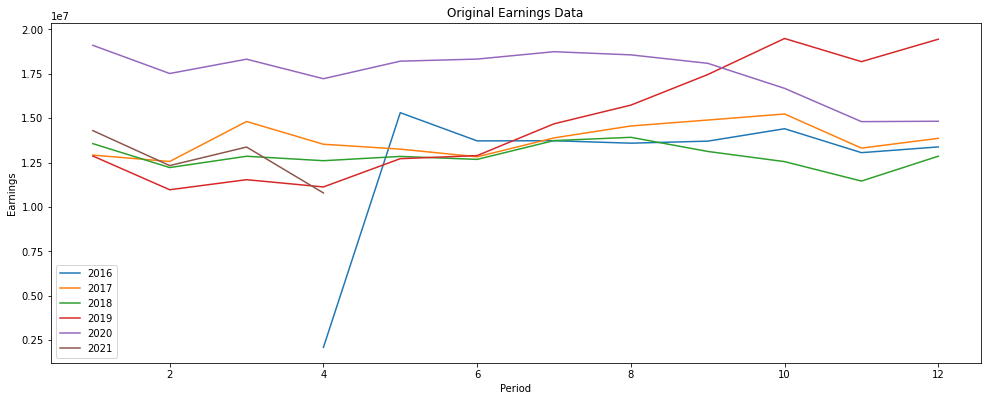

In [34]:
fig, ax = plt.subplots(figsize=(1600/96., 600/96.))
for key, grp in df_stores_total_monthly.groupby(['Year']):
    ax = grp.plot(ax=ax, kind='line', x='Month', y='earnings', label=key)
leg = ax.legend()
plt.title(f'Original Earnings Data')
plt.xlabel('Period')
plt.ylabel('Earnings')

In [ ]:
#drop date column
#df_stores_total_daily = df_stores_total_daily.drop('date', axis = 1)

In [35]:
#split data
data_size = len(df_stores_total_daily.earnings)
test_size = math.floor(.2 * data_size)
print(f'{data_size}, {test_size}')


1825, 365


In [36]:
train_data_df = df_stores_total_daily[:-test_sz]
test_data_df = df_stores_total_daily[-test_sz:]
len(train_data)+len(test_data), len(test_data)

NameError: name 'test_sz' is not defined

In [ ]:
msmin, msmax = train_data.min(), train_data.max()
print(f'Min: {msmin}, Max: {msmax}')
train_data_scaled = (train_data - msmin) / (msmax - msmin)

In [ ]:
fig = px.line(y=train_data_scaled)
fig.update_layout(title=f'Earnings', xaxis_title='date', yaxis_title='earnings', width=960)
fig.show()

# Create Dataset with Lookback

In [ ]:
# lookback window
window = 100

In [ ]:
def gen_dataset(seq_data: np.array, sz: int = 3):
    for i in range(len(seq_data) - sz):
        yield (seq_data[i:i+sz], seq_data[i+sz:i+sz+1])

In [ ]:
range(len(train_data_scaled) - window), len(train_data_scaled)

(range(0, 1360), 1460)

In [ ]:
# try generator
tries = 3
for item in gen_dataset(train_data_scaled):
    print(item)
    tries -= 1
    if tries == 0:
        break
print('Reals:')
print(train_data_scaled[0:3], train_data_scaled[3:4])
print(train_data_scaled[1:4], train_data_scaled[4:5])

(   earnings  Year     Month  WeekOfMonth  WeekOfYear  DayOfMonth  DayOfYear
0  0.626383   0.0  0.272727         0.75    0.313725    0.800000   0.315068
1  0.605420   0.0  0.272727         0.75    0.313725    0.833333   0.317808
2  0.601826   0.0  0.272727         0.75    0.313725    0.866667   0.320548,    earnings  Year     Month  WeekOfMonth  WeekOfYear  DayOfMonth  DayOfYear
3  0.585839   0.0  0.272727         0.75    0.313725         0.9   0.323288)
(   earnings  Year     Month  WeekOfMonth  WeekOfYear  DayOfMonth  DayOfYear
1  0.605420   0.0  0.272727         0.75    0.313725    0.833333   0.317808
2  0.601826   0.0  0.272727         0.75    0.313725    0.866667   0.320548
3  0.585839   0.0  0.272727         0.75    0.313725    0.900000   0.323288,    earnings  Year     Month  WeekOfMonth  WeekOfYear  DayOfMonth  DayOfYear
4  0.580644   0.0  0.272727          1.0    0.313725    0.933333   0.326027)
(   earnings  Year     Month  WeekOfMonth  WeekOfYear  DayOfMonth  DayOfYear
2  0.

In [ ]:
# # generate X, Y pairs
# examples = len(train_data_scaled) - window
# x_train = np.zeros((examples, window))
# y_train = np.zeros((examples))

# itr = gen_dataset(train_data_scaled, window)
# for i, (x, y) in enumerate(itr):
#     x_train[i,:] = x
#     y_train[i] = y

# x_train = torch.FloatTensor(x_train)
# print(x_train)
# y_train = torch.FloatTensor(y_train).view(-1, 1)
# print(y_train)


In [ ]:

#create dataloader for training
train_labels = torch.tensor(train_data_df['earnings'].values.astype(np.float32))
train_features = torch.tensor(train_data_df.drop('earnings', axis = 1).values.astype(np.float32)) 
train_tensor = data_utils.TensorDataset(train_features, train_labels) 
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = 32, num_workers = 1, shuffle = True)

# Model

In [ ]:
# Model params
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


cuda:0


In [ ]:
import torch
import torch.nn as nn

class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        out, (hn) = self.gru(x.view(-1, x.size(1), 1), (h0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model.cuda()

GRU(
  (gru): GRU(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
criterion = torch.nn.MSELoss(reduction='mean').cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

with torch.profiler.profile(
    activities=[
        torch.profiler.ProfilerActivity.CPU,
        torch.profiler.ProfilerActivity.CUDA],
    schedule=torch.profiler.schedule(
        wait=2,
        warmup=3,
        active=6),
    on_trace_ready=torch.profiler.tensorboard_trace_handler('./logs','test'),
    record_shapes=True
) as p:


    for t in range(num_epochs):
        inputs, labels = x_train.cuda(), y_train.cuda()
        y_train_pred = model(inputs)
        loss = criterion(y_train_pred, labels)
        print("Epoch ", t, "MSE: ", loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
        writer.add_scalar('GRU Training Loss', loss.item(), t)
        p.step()

Epoch  0 MSE:  0.24021683633327484
Epoch  1 MSE:  0.05626547336578369
Epoch  2 MSE:  0.09092804789543152
Epoch  3 MSE:  0.06559129804372787
Epoch  4 MSE:  0.033796727657318115
Epoch  5 MSE:  0.03730802610516548
Epoch  6 MSE:  0.04627234861254692
Epoch  7 MSE:  0.04288144409656525
Epoch  8 MSE:  0.029368849471211433
Epoch  9 MSE:  0.01681903563439846


In [ ]:
criterion = torch.nn.MSELoss(reduction='mean').cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

with torch.profiler.profile(
    activities=[
        torch.profiler.ProfilerActivity.CPU,
        torch.profiler.ProfilerActivity.CUDA],
    schedule=torch.profiler.schedule(
        wait=2,
        warmup=3,
        active=6),
    on_trace_ready=torch.profiler.tensorboard_trace_handler('./logs',"test"),
    record_shapes=True
) as p:


    for step, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device=device), data[1].to(device=device)
        y_train_pred = model(inputs)
        loss = criterion(y_train_pred, labels)
        print("Epoch ", t, "MSE: ", loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
        writer.add_scalar('GRU Training Loss', loss.item(), t)
        p.step()

IndexError: dimension specified as 0 but tensor has no dimensions

In [ ]:

# Use profiler to analyze execution time

input = test_data[0]
with profiler.profile(record_shapes=True) as prof:
    with profiler.record_function("model_inference"):
        model(y_train.cuda())
prof.export_chrome_trace("logs/trace.json")

IndexError: dimension specified as 0 but tensor has no dimensions

In [ ]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         6.19%     442.000us        99.50%       7.104ms       7.104ms       0.000us         0.00%     190.000us     190.000us             1  
                                              aten::gru         0.90%      64.000us        49.51%       3.535ms       3.535ms       0.000us         0.00%     116.000us     116.000us             1  
         

In [ ]:
seq = torch.from_numpy(np.array([float(i) for i in range(5)]))
seq1 = torch.from_numpy(np.array([[k for k in range(3)] for i in range(5)]))

In [ ]:
seq1.dim()

2

In [ ]:
sys.path.insert(0, str(Path('..').resolve()))
from tlaloc.data import SequenceDataset

ModuleNotFoundError: No module named 'pytorch_lightning'

In [ ]:
writer.close()